In [1]:
using GpABC,OrdinaryDiffEq, Distances, Distributions, Plots, StatsBase, Printf, ODE, DifferentialEquations, Statistics, ModelingToolkit, CSV
using DelimitedFiles
import Base.Iterators
include("setup_ABC.jl")

gr()

Plots.GRBackend()

In [2]:
function log_euclidean(x,y)
    output = sqrt(sum((log10.(x.+0.00001) - log10.(y.+0.00001)) .^ 2))
    return (output/size(x)[1]) #average by the length of the vector
end

log_euclidean (generic function with 1 method)

In [3]:
@parameters t

@variables s_out(t) rmr(t) em(t) rmq(t) rmt(t) et(t) rmm(t) mt(t) mm(t) q(t) si(t) mq(t) mr(t) r(t) NH4(t) nit_mrna(t) nit_mrna_ribo(t) nit(t) NH4_ex(t) N(t) a(t) AA(t) AA_prot(t) AA_mrna(t) AA_mrna_ribo(t)

#############check the last parameter k_ribo_a
###############

@parameters k_cat_AA k_a_NH4 k_NH4 k_a_AA k_NH4_AA k_a #these are the parameters to be varied in ABC
gam= (gmax*a*AA)/(k_ribo_a*k_ribo_a_AA+k_ribo_a_AA*a+k_ribo_AA_a*AA+a*AA) #updated gamma equation that uses both ATP and AA
ttrate= (rmq + rmr + rmt + rmm + nit_mrna_ribo+AA_mrna_ribo)*gam #total translation rate (sum of the mRNA/ribosome complexes times translation rate)
lam= ttrate/M #lambda is the growth rate
nucat= em*vm*si/(Km + abs(si))
AA_vo = ((k_cat_AA*2*a*NH4)/(k_a_NH4*k_a))/(1+(1+(AA/k_a_AA))+(NH4/k_a_NH4)+(1+(AA/k_NH4_AA))+(NH4/k_NH4))
new_AA = AA_vo*AA_prot
AA_a_use = new_AA*2 #each AA produced uses x number of ATP molecules
AA_NH4_use = new_AA*2 #each AA produced uses 2 NH4 molecules
export_rate = 0 #export rate of NH4
fixation = 0
death_rate = 0
k_ribo_a_AA = 10000.0
k_ribo_AA_a = 10000.0
k_ribo_a = 10.0

@derivatives D'~t

eqs = [
    D(s_out)~ 0 #((-et*vt*s_out/(Kt+s_out))*N)-ds*s_out+(export_rate*NH4*50)+1e7
    D(rmr)~ kb*r*mr-ku*rmr-(gam/nr)*rmr-lam*rmr
    D(em)~ (gam/nx)*rmm-lam*em
    D(rmq)~ kb*r*mq-ku*rmq-(gam/nx)*rmq-lam*rmq
    D(rmt)~ kb*r*mt-ku*rmt-gam/nx*rmt-lam*rmt
    D(et)~ (gam/nx)*rmt-lam*et
    D(rmm)~ kb*r*mm-ku*rmm-gam/nx*rmm-lam*rmm
    D(mt)~ (we*a/(thetax+a))+ku*rmt+(gam/nx)*rmt-kb*r*mt-dm*mt-lam*mt
    D(mm)~ (we*a/(thetax+a))+ku*rmm+(gam/nx)*rmm-kb*r*mm-dm*mm-lam*mm
    D(q)~ (gam/nx)*rmq-lam*q
    D(si)~ (et*vt*s_out/(Kt+s_out))-nucat-lam*si
    D(mq)~ (wq*a/(thetax+a)/(1+(q/Kq)^nq))+ku*rmq+(gam/nx)*rmq-kb*r*mq-dm*mq-lam*mq
    D(mr)~ (wr*a/(thetar+a))+ku*rmr+(gam/nr)*rmr-kb*r*mr-dm*mr-lam*mr
    D(r)~ ku*rmr+ku*rmt+ku*rmm+ku*rmq+(gam/nr)*rmr+(gam/nr)*rmr+(gam/nx)*rmt+(gam/nx)*rmm+(gam/nx)*rmq-kb*r*mr-kb*r*mt-kb*r*mm-kb*r*mq+ku*nit_mrna_ribo+(gam/nx)*nit_mrna_ribo-kb*r*nit_mrna+ku*AA_mrna_ribo+(gam/nx)*AA_mrna_ribo-kb*r*AA_mrna-lam*r
    D(NH4)~ 0 #fixation*nit-export_rate*NH4-lam*NH4-AA_NH4_use+2.3e6
    D(nit_mrna)~ 0 #(v_nit*a/(thetax + a))+(ku*nit_mrna_ribo)+(gam/nx*nit_mrna_ribo)-(kb*r*nit_mrna)-(dm*nit_mrna)-(lam*nit_mrna) #num of free nitrogenase coding mRNA
    D(nit_mrna_ribo)~ 0 #(kb*r*nit_mrna)-(ku*nit_mrna_ribo)-(gam/nx*nit_mrna_ribo)-(lam*nit_mrna_ribo) #num of nit mRNA-ribosome complexes
    D(nit)~ 0 #(gam/nx)*nit_mrna_ribo-lam*nit #num of nitrogenase proteins
    D(NH4_ex)~ 0 #(export_rate*NH4)#total num of NH4 molecules exported this timestep
    D(N)~ 0 #lam*N-death_rate*N #the change in num of bacterial cells instead of just loss to dilution
    D(a)~ ns*nucat-ttrate-fixation*nit-AA_a_use-lam*a
    D(AA)~ new_AA-ttrate-lam*AA
    D(AA_prot)~ (gam/nx)*AA_mrna_ribo-lam*AA_prot
    D(AA_mrna)~ ((w_AA*a/(thetax+a)))+(ku*AA_mrna_ribo)+(gam/nx*AA_mrna_ribo)-(kb*r*AA_mrna)-(dm*AA_mrna)-(lam*AA_mrna)
    D(AA_mrna_ribo)~ (kb*r*AA_mrna)-(ku*AA_mrna_ribo)-(gam/nx*AA_mrna_ribo)-(lam*AA_mrna_ribo)
];

println("System defined successfully")

System defined successfully


In [4]:
de = ODESystem(eqs, t, [s_out, rmr, em, rmq, rmt, 
        et, rmm, mt, mm, q, si, mq, mr, r, NH4, nit_mrna,
        nit_mrna_ribo, nit, NH4_ex, N, a, AA, AA_prot,
        AA_mrna, AA_mrna_ribo],[k_cat_AA,k_a_NH4 ,k_NH4, k_a_AA, k_NH4_AA, k_a])

f = ODEFunction(de)
p = [10.0,10.0,10.0,10.0,10.0,10.0]
burn_in_prob_abc = ODEProblem(f, init, (0.,10000.0),p) #set up the burn in problem

println("burning in model")
sol = solve(burn_in_prob_abc)
println("success")
step_num = size(sol,2)
final_state =sol[step_num] #run the burn in stage and collect the end state to use as new initial values

prob_abc = ODEProblem(f, final_state, (0.,10000.0),p) #the problem to run ABC on using the burned in initial values

burning in model
success


ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10000.0)
u0: [1.0e11, 1433.7935898638818, 547.7276435794657, 1352.8302553986343, 7.160976755336487, 547.7276435794676, 7.16097675533649, 39.131453539252924, 39.13145353925297, 103475.06368697481  …  3.2845105566973926e-14, -3.242118686375807e-14, 0.0, 0.0, 1.0, 879.6320760648405, 4.328441256015495e9, 119095.04047006265, 8508.539047716775, 1557.0454156898122]

In [5]:
function simulator_function_lm(params, time1= 10000.0)
    global k_cat_AA = params[1]
    global k_a_NH4 = 10. #params[2]
    global k_NH4 = 10. #params[3]
    global k_a_AA = 10. #params[4]
    global k_NH4_AA = 10.# params[5]
    global k_a = 10. #params[6]
    prob = ODEProblem(AA_simple,init,(0.,time1))
    sol = ODE.solve(prob, saveat = 1.)
    return Array{Float64, 2}(sol)
end

simulator_function_lm (generic function with 2 methods)

In [9]:
# params_lm = [0.7,1.0,1.0]#,1.0,1.0,1.0]
# results = simulator_function_lm(params_lm);
plot(results', ylims= (-1e4,1.2e5), legend = false )

In [17]:
population_colors=["#FF2F4E", "#D0001F", "#A20018", "#990017", "#800013"]

threshold_schedule = [0.01,0.005,0.001, 0.0007, 0.0005, 0.0001];
priors = [Uniform(0., 20.0)]#, Uniform(0.,20.0), Uniform(0., 20.0)]#,
#     Uniform(2., 30.), Uniform(2., 30.), Uniform(2., 30.)]
n_particles = 300

random_vect = []
estimated_vect = []
difference_vect = []


0-element Array{Any,1}

In [18]:
params_lm = rand(1)*20
results = simulator_function_lm(params_lm);

#run abc smc to try and recreate the 3 random param values
sim_abcsmc_res = SimulatedABCSMC(results,
    simulator_function_lm,
    priors,
    threshold_schedule,
    n_particles,
    distance_function = log_euclidean,
    max_iter=convert(Int, 2e6),
    write_progress=true)

mean1 = mean(sim_abcsmc_res.population[6][:,1])
mode1 = mode(sim_abcsmc_res.population[6][:,1])


┌ Info: GpABC rejection simulation. ϵ = 0.01.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 299/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 201/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238


17.767158774248827

In [16]:
sim_abcsmc_res.n_tries #[0.1, 0.07, 0.05, 0.03, 0.01,0.005] 
#only the 0.005 was low enough to need refuse some particles, the others are accepting all particles

6-element Array{Int64,1}:
  300
  300
  300
  300
  300
 1485

In [ ]:
plot(sim_abcsmc_res)
vline!(params_lm)

In [217]:
mean1 = mean(sim_abcsmc_res.population[6][:,1])
mode1 = mode(sim_abcsmc_res.population[6][:,1])

println("mean is $mean1")
println("mode is $mode1")

mean is 11.44441340471229
mode is 14.714638481664117


In [20]:
param_vect = [0.5, 10.2, 19.5]
for i in range(1,stop = 3)
println(param_vect[i])
end

0.5
10.2
19.5


In [21]:
for i in range(1,stop = 3)

#generate dummy data with 3 random params between 0 and 20
params_lm = param_vect[i]
results = simulator_function_lm(params_lm);

#run abc smc to try and recreate the 3 random param values
sim_abcsmc_res = SimulatedABCSMC(results,
    simulator_function_lm,
    priors,
    threshold_schedule,
    n_particles,
    distance_function = log_euclidean,
    max_iter=convert(Int, 2e6),
    write_progress=true)

mean1 = mean(sim_abcsmc_res.population[6][:,1])
mode1 = mode(sim_abcsmc_res.population[6][:,1])

    ##pull out maximum as well as the mean of the final pop
    
# mean2 =mean(sim_abcsmc_res.population[6][:,2])
# mean3 = mean(sim_abcsmc_res.population[6][:,3])
println("estimated paramters are")
println(mean1)#," ", mean2, " ",mean3)
push!(estimated_vect, mean1)
println("true parameters are")
println(params_lm)
push!(random_vect, params_lm)
println("difference for round $i is")
println(euclidean([mean1],params_lm)) #println(euclidean([mean1,mean2,mean3],params_lm))
push!(difference_vect,euclidean([mean1],params_lm))
    
end

┌ Info: GpABC rejection simulation. ϵ = 0.01.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 142/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 276/2000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 200/1000 particles.
└

estimated paramters are
0.5310693347363376
true parameters are
0.5
difference for round 1 is


MethodError: MethodError: no method matching euclidean(::Array{Float64,1}, ::Float64)
Closest candidates are:
  euclidean(::AbstractArray, !Matched::AbstractArray) at C:\Users\leann\.julia\packages\Distances\jwhuc\src\metrics.jl:281
  euclidean(!Matched::Number, ::Number) at C:\Users\leann\.julia\packages\Distances\jwhuc\src\metrics.jl:282

In [22]:
writedlm("ABC_SMC_differences.txt", difference_vect, ",")

In [62]:
random_vect= collect(Iterators.flatten(random_vect))

54-element Array{Float64,1}:
 19.608404820961102 
  6.559671528880546 
  3.4225029227479364
  4.615715985338009 
  5.7406781155062925
 17.969374896018216 
 15.201990173350953 
 15.208267605398426 
  3.68959082500826  
 14.910915709954352 
 18.297847925259777 
  4.054908878019332 
  2.269917946050235 
  ⋮                 
 17.130109618366248 
 11.902760977381632 
  6.45523036521964  
  1.323329469136616 
  2.6196327238040507
  7.550702534354179 
  9.532016729965513 
 10.113797485852016 
  2.1638738814159764
 15.960059436899554 
  5.305057849264712 
  7.755516309323709 

In [24]:
difference_vect

0-element Array{Any,1}

In [116]:
paired_values = collect(zip(random_vect, estimated_vect))
paired_values = sort(paired_values);

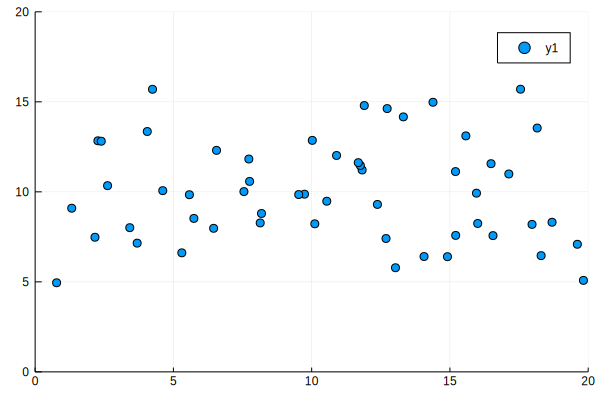

In [159]:
scatter(random_vect, estimated_vect,xlim= (0,20), ylim = (0,20))

In [181]:
paired_values

54-element Array{Tuple{Float64,Any},1}:
 (0.7763021730441588, 4.949376835548665) 
 (1.323329469136616, 9.091098185845123)  
 (2.1638738814159764, 7.477886645872473) 
 (2.269917946050235, 12.835978767730797) 
 (2.391464543043802, 12.812182288364875) 
 (2.6196327238040507, 10.343647406608442)
 (3.4225029227479364, 8.009539043057972) 
 (3.68959082500826, 7.150547555328322)   
 (4.054908878019332, 13.35130659150699)  
 (4.2448798270350485, 15.696233738180878)
 (4.615715985338009, 10.06644691650888)  
 (5.305057849264712, 6.611973021580197)  
 (5.57867401733636, 9.840013774731212)   
 ⋮                                       
 (15.960059436899554, 9.926425748749594) 
 (16.004552899753868, 8.243723258354168) 
 (16.486658644602166, 11.564682020873704)
 (16.55724298995022, 7.568848750114698)  
 (17.130109618366248, 10.992735766037892)
 (17.553941894693562, 15.700554813403885)
 (17.969374896018216, 8.192033389481209) 
 (18.155545720562746, 13.54439610497)    
 (18.297847925259777, 6.456283577848

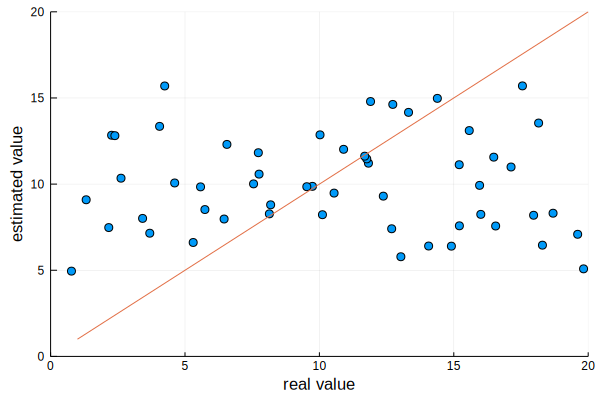

In [187]:
x = random_vect
y = estimated_vect
scatter(x,y, xlim = (0,20), ylim = (0,20),
    xlab = "real value",
    ylab = "estimated value",
    legend = false )
plot!(range(1,stop =20))

In [203]:
scatter(random_vect, difference_vect, ylab = "difference", xlab ="real value")

BoundsError: BoundsError: attempt to access 52-element Array{Float64,1} at index [53]

In [205]:
difference_vect

52-element Array{Any,1}:
  4.587036120310035  
  5.450730931170871  
  2.783033908927602  
  9.777341506537008  
  4.075762433180369  
  7.628730762639015  
  3.4609567303200626 
  8.511996382187451  
 11.841564347411325  
  9.296397713487657  
 10.566060821680562  
  0.13446117972533855
  1.8533870812896769 
  ⋮                  
  6.137373852328356  
  2.890888813425022  
  1.5187370532030595 
  7.767768716708507  
  7.724014682804391  
  2.462692632187399  
  0.3177419945395705 
  1.8895516557204637 
  5.314012764456496  
  6.03363368814996   
  1.3069151723154855 
  2.8241016398067034 